# TB Drug Susceptibility Testing: Classification

**Project:** Area-based approach for antibiotic resistance classification

---

## Overview

This notebook implements classification approaches for distinguishing resistant from susceptible bacterial strains:

1. **Threshold-Based Classification:** Simple rules based on fold-change
2. **Machine Learning Classification:** Logistic regression on area features
3. **Early Detection Analysis:** Testing classification at 3h, 6h, 9h, 12h
4. **Sparse vs. Continuous Comparison:** Evaluating feature efficiency

## Dataset

- **REF (Resistant):** 10 samples (Pos101-110)
- **RIF10 (Susceptible):** 10 paired samples (Pos201-210)
- **Features:** Area measurements at [0h, 3h, 6h, 9h, 12h]

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from PIL import Image
import seaborn as sns
from scipy import stats
import warnings

# Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" Libraries imported successfully!")

 Libraries imported successfully!


### Configuration

In [2]:
# CONFIGURATION

# For Google Colab
USE_COLAB = True  # Set to False if running locally

if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_DIR = "/content/drive/MyDrive/data"
else:
    BASE_DIR = "./data"  # Local path

# Data directories
REF_MASK_DIR = Path(BASE_DIR) / "REF_masks101_110"
RIF_MASK_DIR = Path(BASE_DIR) / "RIF10_masks201_210"

# Output directory
OUTPUT_DIR = Path("./outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

# Constants
PIXEL_SIZE = 0.065  # μm per pixel
FRAME_INTERVAL = 0.1  # hours per frame
SPARSE_TIMEPOINTS = [0, 3, 6, 9, 12]  # hours
RANDOM_STATE = 42

print(f" Configuration complete")

Mounted at /content/drive
 Configuration complete


## 2. Load Data

In [3]:
def load_area_data(mask_base_dir, position_range=(101, 110), pixel_size=0.065):
    """Load bacterial area measurements from mask TIFF files."""
    mask_base_path = Path(mask_base_dir)
    positions = list(range(position_range[0], position_range[1] + 1))
    area_data = {}

    for position in positions:
        pos_string = f'Pos{position}'
        mask_dir = mask_base_path / pos_string / 'PreprocessedPhaseMasks'

        if not mask_dir.exists():
            continue

        mask_files = sorted([f for f in mask_dir.iterdir()
                           if f.name.startswith('MASK_') and f.name.endswith('.tif')])

        if not mask_files:
            continue

        areas = []
        for mask_file in mask_files:
            mask = np.array(Image.open(mask_file)) > 0
            area_pixels = mask.sum()
            area_um2 = area_pixels * (pixel_size ** 2)
            areas.append(area_um2)

        area_data[pos_string] = np.array(areas)
        print(f"  {pos_string}: {len(areas)} timepoints")

    return area_data

def extract_sparse_timepoints(area_timeseries, target_hours=[0, 3, 6, 9, 12],
                              frame_interval_hours=0.1):
    """Extract area measurements at specific timepoints."""
    frame_indices = [int(h / frame_interval_hours) for h in target_hours]
    max_frame = len(area_timeseries) - 1
    frame_indices = [min(idx, max_frame) for idx in frame_indices]
    return area_timeseries[frame_indices]

# Load data
print("Loading REF (resistant) data...")
ref_areas = load_area_data(REF_MASK_DIR, position_range=(101, 110))
print(f"\n Loaded {len(ref_areas)} REF positions\n")

print("Loading RIF10 (susceptible) data...")
rif10_areas = load_area_data(RIF_MASK_DIR, position_range=(201, 220))
print(f"\n Loaded {len(rif10_areas)} RIF10 positions")

Loading REF (resistant) data...
  Pos101: 121 timepoints
  Pos102: 121 timepoints
  Pos103: 121 timepoints
  Pos104: 121 timepoints
  Pos105: 121 timepoints
  Pos106: 121 timepoints
  Pos107: 121 timepoints
  Pos108: 121 timepoints
  Pos109: 121 timepoints
  Pos110: 121 timepoints

 Loaded 10 REF positions

Loading RIF10 (susceptible) data...
  Pos201: 121 timepoints
  Pos202: 121 timepoints
  Pos203: 121 timepoints
  Pos204: 121 timepoints
  Pos205: 121 timepoints
  Pos206: 121 timepoints
  Pos207: 121 timepoints
  Pos208: 121 timepoints
  Pos209: 121 timepoints
  Pos210: 121 timepoints
  Pos211: 121 timepoints
  Pos212: 121 timepoints
  Pos213: 121 timepoints
  Pos214: 121 timepoints
  Pos215: 121 timepoints
  Pos216: 121 timepoints
  Pos217: 121 timepoints
  Pos218: 121 timepoints
  Pos219: 121 timepoints
  Pos220: 121 timepoints

 Loaded 20 RIF10 positions


In [4]:
# Prepare data for classification
ref_ids = list(range(101, 111))
rif10_ids = list(range(201, 211))  # Only paired positions

def get_sparse_areas(areas_dict, position_ids, timepoints, frame_interval):
    """Extract sparse timepoints for given positions."""
    sparse_data = []
    for pos_id in position_ids:
        pos_name = f'Pos{pos_id}'
        if pos_name not in areas_dict:
            continue
        areas = np.array(areas_dict[pos_name])
        timepoint_areas = []
        for t in timepoints:
            idx = int(t / frame_interval)
            idx = min(idx, len(areas) - 1)
            timepoint_areas.append(areas[idx])
        sparse_data.append(timepoint_areas)
    return np.array(sparse_data)

ref_sparse = get_sparse_areas(ref_areas, ref_ids, SPARSE_TIMEPOINTS, FRAME_INTERVAL)
rif10_sparse = get_sparse_areas(rif10_areas, rif10_ids, SPARSE_TIMEPOINTS, FRAME_INTERVAL)

print(f"  REF:   {ref_sparse.shape[0]} samples × {ref_sparse.shape[1]} timepoints")
print(f"  RIF10: {rif10_sparse.shape[0]} samples × {rif10_sparse.shape[1]} timepoints")

  REF:   10 samples × 5 timepoints
  RIF10: 10 samples × 5 timepoints


## 3. Threshold-Based Classification

Simple approach: Classify based on fold-change and absolute growth.

### 3.1 Threshold Selection

We use a **fold change threshold of 2.0×** as our classification criterion:
- **Fold change ≥ 2.0** → Resistant (exponential growth, at least doubled)
- **Fold change < 2.0** → Susceptible (growth arrested)


This threshold was chosen empirically by examining our data—resistant strains typically show 2-3× growth over 12h, while susceptible strains show <1.5× due to rifampicin-induced arrest. However, **this threshold is adjustable** depending on:
- Antibiotic concentration
- Bacterial strain characteristics  
- Experimental duration
- Desired sensitivity/specificity balance


In [7]:
def classify_by_threshold_at_time(areas_dict, target_hour=12, threshold_fold=2.0,
                                   frame_interval=0.1):
    """
    Classify positions as resistant or susceptible at a specific timepoint.

    Resistant if: Fold change >= threshold_fold at target_hour

    Parameters:
    -----------
    areas_dict : dict
        Dictionary of position areas (full timeseries)
    target_hour : int
        Hour at which to evaluate (e.g., 9 for 9h)
    threshold_fold : float
        Minimum fold change for resistance
    frame_interval : float
        Time between frames in hours

    Returns:
    --------
    DataFrame with classification results
    """
    results = []

    for pos_name, areas in areas_dict.items():
        areas = np.array(areas, dtype=float)

        initial = areas[0]

        # Get area at target hour
        target_frame = int(target_hour / frame_interval)
        target_frame = min(target_frame, len(areas) - 1)
        area_at_target = areas[target_frame]

        growth = area_at_target - initial
        fold_change = area_at_target / initial if initial > 0 else 0

        is_resistant = fold_change >= threshold_fold
        classification = "RESISTANT" if is_resistant else "SUSCEPTIBLE"

        results.append({
            'Position': pos_name,
            'Initial_Area': initial,
            f'Area_at_{target_hour}h': area_at_target,
            'Absolute_Growth': growth,
            'Fold_Change': fold_change,
            'Classification': classification
        })

    return pd.DataFrame(results)

### 12h Detection

In [8]:
# THRESHOLD CLASSIFICATION AT 12h (Full Duration)
print("THRESHOLD-BASED CLASSIFICATION AT 12h")

print("\nREF (Untreated/Resistant):")
ref_classification_12h = classify_by_threshold(ref_areas, threshold_fold=2.0)
print(ref_classification_12h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
print(f"\nSummary: {(ref_classification_12h['Classification'] == 'RESISTANT').sum()} resistant, "
      f"{(ref_classification_12h['Classification'] == 'SUSCEPTIBLE').sum()} susceptible")

print("\nRIF10 (Treated/Susceptible):")
rif10_classification_12h = classify_by_threshold(rif10_areas, threshold_fold=2.0)
print(rif10_classification_12h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
print(f"\nSummary: {(rif10_classification_12h['Classification'] == 'RESISTANT').sum()} resistant, "
      f"{(rif10_classification_12h['Classification'] == 'SUSCEPTIBLE').sum()} susceptible")

# Calculate overall accuracy at 12h
total_correct_12h = (ref_classification_12h['Classification'] == 'RESISTANT').sum() + \
                     (rif10_classification_12h['Classification'] == 'SUSCEPTIBLE').sum()
total_samples_12h = len(ref_classification_12h) + len(rif10_classification_12h)
accuracy_12h = total_correct_12h / total_samples_12h * 100

print(f"\n Overall Accuracy at 12h: {accuracy_12h:.1f}% ({total_correct_12h}/{total_samples_12h})")


THRESHOLD-BASED CLASSIFICATION AT 12h

REF (Untreated/Resistant):
Position  Initial_Area  Final_Area  Absolute_Growth  Fold_Change Classification
  Pos101         44.45      131.62            87.17         2.96      RESISTANT
  Pos102         42.41      123.51            81.11         2.91      RESISTANT
  Pos103         17.39       47.45            30.05         2.73      RESISTANT
  Pos104         68.80      186.59           117.79         2.71      RESISTANT
  Pos105         35.00       85.26            50.26         2.44      RESISTANT
  Pos106         75.64      210.98           135.34         2.79      RESISTANT
  Pos107         66.91      181.18           114.27         2.71      RESISTANT
  Pos108         56.96      168.24           111.27         2.95      RESISTANT
  Pos109        139.50      451.62           312.12         3.24      RESISTANT
  Pos110         70.67      193.20           122.53         2.73      RESISTANT

Summary: 10 resistant, 0 susceptible

RIF10 (Treated/

### 9h Detection

In [12]:
# THRESHOLD CLASSIFICATION AT 9h (Early Detection)
print("THRESHOLD-BASED CLASSIFICATION AT 9h (EARLY DETECTION)")

print("\nREF (Untreated/Resistant):")
ref_classification_9h = classify_by_threshold_at_time(ref_areas, target_hour=9,
                                                       threshold_fold=2.0)
print(ref_classification_9h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
print(f"\nSummary: {(ref_classification_9h['Classification'] == 'RESISTANT').sum()} resistant, "
      f"{(ref_classification_9h['Classification'] == 'SUSCEPTIBLE').sum()} susceptible")

print("\nRIF10 (Treated/Susceptible):")
rif10_classification_9h = classify_by_threshold_at_time(rif10_areas, target_hour=9,
                                                         threshold_fold=2.0)
print(rif10_classification_9h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
print(f"\nSummary: {(rif10_classification_9h['Classification'] == 'RESISTANT').sum()} resistant, "
      f"{(rif10_classification_9h['Classification'] == 'SUSCEPTIBLE').sum()} susceptible")

# Calculate overall accuracy at 9h
total_correct_9h = (ref_classification_9h['Classification'] == 'RESISTANT').sum() + \
                    (rif10_classification_9h['Classification'] == 'SUSCEPTIBLE').sum()
total_samples_9h = len(ref_classification_9h) + len(rif10_classification_9h)
accuracy_9h = total_correct_9h / total_samples_9h * 100

print(f"\n Overall Accuracy at 9h: {accuracy_9h:.1f}% ({total_correct_9h}/{total_samples_9h})")
print(f" Time saved: 3h")


THRESHOLD-BASED CLASSIFICATION AT 9h (EARLY DETECTION)

REF (Untreated/Resistant):
Position  Initial_Area  Area_at_9h  Absolute_Growth  Fold_Change Classification
  Pos101         44.45      100.11            55.66         2.25      RESISTANT
  Pos102         42.41       90.93            48.52         2.14      RESISTANT
  Pos103         17.39       36.74            19.34         2.11      RESISTANT
  Pos104         68.80      139.55            70.75         2.03      RESISTANT
  Pos105         35.00       71.02            36.03         2.03      RESISTANT
  Pos106         75.64      165.59            89.95         2.19      RESISTANT
  Pos107         66.91      138.12            71.21         2.06      RESISTANT
  Pos108         56.96      127.15            70.19         2.23      RESISTANT
  Pos109        139.50      335.83           196.33         2.41      RESISTANT
  Pos110         70.67      149.77            79.10         2.12      RESISTANT

Summary: 10 resistant, 0 susceptible

### 6h Detection

In [13]:
# THRESHOLD CLASSIFICATION AT 6h (Early Detection)
print("THRESHOLD-BASED CLASSIFICATION AT 6h (EARLY DETECTION)")

print("\nREF (Untreated/Resistant):")
ref_classification_6h = classify_by_threshold_at_time(ref_areas, target_hour=6,
                                                       threshold_fold=2.0)
print(ref_classification_6h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
print(f"\nSummary: {(ref_classification_6h['Classification'] == 'RESISTANT').sum()} resistant, "
      f"{(ref_classification_6h['Classification'] == 'SUSCEPTIBLE').sum()} susceptible")

print("\nRIF10 (Treated/Susceptible):")
rif10_classification_6h = classify_by_threshold_at_time(rif10_areas, target_hour=6,
                                                         threshold_fold=2.0)
print(rif10_classification_6h.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
print(f"\nSummary: {(rif10_classification_6h['Classification'] == 'RESISTANT').sum()} resistant, "
      f"{(rif10_classification_6h['Classification'] == 'SUSCEPTIBLE').sum()} susceptible")

# Calculate overall accuracy at 6h
total_correct_6h = (ref_classification_6h['Classification'] == 'RESISTANT').sum() + \
                    (rif10_classification_6h['Classification'] == 'SUSCEPTIBLE').sum()
total_samples_6h = len(ref_classification_6h) + len(rif10_classification_6h)
accuracy_6h = total_correct_6h / total_samples_6h * 100

print(f"\n Overall Accuracy at 6h: {accuracy_6h:.1f}% ({total_correct_6h}/{total_samples_6h})")
print(f" Time saved: 6h")


THRESHOLD-BASED CLASSIFICATION AT 6h (EARLY DETECTION)

REF (Untreated/Resistant):
Position  Initial_Area  Area_at_6h  Absolute_Growth  Fold_Change Classification
  Pos101         44.45       75.97            31.53         1.71    SUSCEPTIBLE
  Pos102         42.41       69.93            27.52         1.65    SUSCEPTIBLE
  Pos103         17.39       27.19             9.80         1.56    SUSCEPTIBLE
  Pos104         68.80      109.67            40.88         1.59    SUSCEPTIBLE
  Pos105         35.00       55.79            20.80         1.59    SUSCEPTIBLE
  Pos106         75.64      126.08            50.45         1.67    SUSCEPTIBLE
  Pos107         66.91      109.71            42.80         1.64    SUSCEPTIBLE
  Pos108         56.96       98.12            41.16         1.72    SUSCEPTIBLE
  Pos109        139.50      255.45           115.96         1.83    SUSCEPTIBLE
  Pos110         70.67      112.17            41.50         1.59    SUSCEPTIBLE

Summary: 0 resistant, 10 susceptible

### 6h Detection: Why It Fails

**66.7% accuracy—everything classified as susceptible!**

This confirms our trajectory analysis: at 6h, both groups are still growing with similar fold changes (1.5-1.8×). The diagnostic decline in RIF10 hasn't occurred yet.

**Problems with threshold approach:**
- No threshold separates the classes at 6h
- 66.7% only looks "okay" because of class imbalance (20 RIF10 vs 10 REF)
- Classifier simply guesses "susceptible" for everything


## 4. Machine Learning Classification

### 4.1 Prepare Dataset

In [14]:
# Create ML dataset (using paired positions only: 101-110 and 201-210)
X = np.vstack([ref_sparse, rif10_sparse])
y = np.array([1]*10 + [0]*10)  # 1 = resistant, 0 = susceptible

print("ML DATASET")
print(f"\nFeatures: {X.shape}")
print(f"  Shape: {X.shape[0]} samples × {X.shape[1]} features")
print(f"  Features: Area at {SPARSE_TIMEPOINTS} hours")
print(f"\nLabels: {y.shape}")
print(f"  Resistant (1): {np.sum(y==1)} samples")
print(f"  Susceptible (0): {np.sum(y==0)} samples")

ML DATASET

Features: (20, 5)
  Shape: 20 samples × 5 features
  Features: Area at [0, 3, 6, 9, 12] hours

Labels: (20,)
  Resistant (1): 10 samples
  Susceptible (0): 10 samples


### 4.2 Train Logistic Regression with Cross-Validation

In [15]:
def train_logistic_regression(X, y, n_folds=5, random_state=42):
    """
    Train logistic regression classifier with cross-validation.

    Parameters:
    -----------
    X : array
        Features
    y : array
        Labels (1=resistant, 0=susceptible)
    n_folds : int
        Number of cross-validation folds
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    model, scaler, cv_scores
    """

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create model
    model = LogisticRegression(
        random_state=random_state,
        max_iter=1000,
        class_weight='balanced'
    )

    # Cross-validation
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')

    # Train final model on all data
    model.fit(X_scaled, y)

    return model, scaler, cv_scores


print("LOGISTIC REGRESSION CLASSIFICATION")
print("\nTraining model...")

model, scaler, cv_scores = train_logistic_regression(X, y)

print(f"\n5-Fold Cross-Validation Results:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score*100:5.1f}%")
print(f"\n Mean Accuracy: {cv_scores.mean()*100:.1f}% ± {cv_scores.std()*100:.1f}%")

LOGISTIC REGRESSION CLASSIFICATION

Training model...

5-Fold Cross-Validation Results:
  Fold 1: 100.0%
  Fold 2: 100.0%
  Fold 3:  75.0%
  Fold 4: 100.0%
  Fold 5: 100.0%

 Mean Accuracy: 95.0% ± 10.0%


### Test Set Limitation

 **Testing only on susceptible strains:** Our test set contains only RIF10 positions (211-220), all susceptible. Ideally, we'd test on both resistant and susceptible unseen samples, but our small dataset (only 10 REF total) prevents this. Cross-validation remains our best estimate for performance on resistant strains.

In [16]:
# TEST ON UNSEEN DATA (Positions 211-220)

print("TESTING ON UNSEEN RIF10 POSITIONS (211-220)")

rif10_test_ids = list(range(211, 221))  # 10 additional positions
rif10_test_sparse = get_sparse_areas(rif10_areas, rif10_test_ids,
                                      SPARSE_TIMEPOINTS, FRAME_INTERVAL)

print(f"Test set: {rif10_test_sparse.shape[0]} RIF10 samples (all should be susceptible)")
print()

# predictions
X_test_scaled = scaler.transform(rif10_test_sparse)
y_test_pred = model.predict(X_test_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

y_test_true = np.array([0] * len(rif10_test_sparse))

# Results
print("Predictions:")
for i, pos_id in enumerate(rif10_test_ids):
    pred_label = "SUSCEPTIBLE" if y_test_pred[i] == 0 else "RESISTANT"
    confidence = y_test_prob[i][y_test_pred[i]] * 100
    status = "✓" if y_test_pred[i] == 0 else "✗"
    print(f"  {status} Pos{pos_id}: {pred_label} (confidence: {confidence:.1f}%)")

# Test accuracy
test_accuracy = accuracy_score(y_test_true, y_test_pred)
correct = np.sum(y_test_pred == 0)  # Should all be 0 (susceptible)

print()
print(f" Test Accuracy: {test_accuracy*100:.1f}% ({correct}/{len(y_test_pred)} correct)")
print()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test_true, y_test_pred)
print("Test Confusion Matrix:")
print("                 Predicted")
print("                 Susc  Resi")
print(f"Actual Susc      {cm_test[0,0]:4d}  {cm_test[0,1]:4d}")


TESTING ON UNSEEN RIF10 POSITIONS (211-220)
Test set: 10 RIF10 samples (all should be susceptible)

Predictions:
  ✓ Pos211: SUSCEPTIBLE (confidence: 65.2%)
  ✓ Pos212: SUSCEPTIBLE (confidence: 91.0%)
  ✓ Pos213: SUSCEPTIBLE (confidence: 98.2%)
  ✗ Pos214: RESISTANT (confidence: 56.0%)
  ✗ Pos215: RESISTANT (confidence: 59.8%)
  ✓ Pos216: SUSCEPTIBLE (confidence: 74.0%)
  ✓ Pos217: SUSCEPTIBLE (confidence: 58.1%)
  ✓ Pos218: SUSCEPTIBLE (confidence: 68.7%)
  ✓ Pos219: SUSCEPTIBLE (confidence: 75.8%)
  ✗ Pos220: RESISTANT (confidence: 71.5%)

 Test Accuracy: 70.0% (7/10 correct)

Test Confusion Matrix:
                 Predicted
                 Susc  Resi
Actual Susc         7     3


## 5. Early Detection Analysis

Test classification accuracy at different timepoints: 3h, 6h, 9h, 12h

In [17]:
test_hours = [3, 6, 9, 12]
results_early = []

print("EARLY DETECTION ANALYSIS")

for max_hour in test_hours:
    hour_idx = SPARSE_TIMEPOINTS.index(max_hour) + 1

    X_early = np.vstack([ref_sparse[:, :hour_idx], rif10_sparse[:, :hour_idx]])

    scaler_early = StandardScaler()
    X_early_scaled = scaler_early.fit_transform(X_early)
    model_early = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000,
                                     class_weight='balanced')

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores_early = cross_val_score(model_early, X_early_scaled, y, cv=cv,
                                      scoring='accuracy')

    accuracy = cv_scores_early.mean()
    std = cv_scores_early.std()

    print(f"Detection at {max_hour}h (using {hour_idx} timepoints):")
    print(f"  Features: {SPARSE_TIMEPOINTS[:hour_idx]}")
    print(f"  Accuracy: {accuracy:.1%} ± {std:.1%}")
    print()

    results_early.append({
        'hour': max_hour,
        'n_timepoints': hour_idx,
        'accuracy': accuracy,
        'std': std
    })

# Find earliest reliable detection
reliable = [r for r in results_early if r['accuracy'] >= 0.90]
if reliable:
    earliest = reliable[0]
    print(f"\n EARLIEST RELIABLE DETECTION: {earliest['hour']}h")
    print(f"  Accuracy: {earliest['accuracy']:.1%}")
    print(f"  Time saved vs 12h: {12 - earliest['hour']}h ({(12-earliest['hour'])/12*100:.0f}% reduction)")

EARLY DETECTION ANALYSIS
Detection at 3h (using 2 timepoints):
  Features: [0, 3]
  Accuracy: 70.0% ± 18.7%

Detection at 6h (using 3 timepoints):
  Features: [0, 3, 6]
  Accuracy: 70.0% ± 18.7%

Detection at 9h (using 4 timepoints):
  Features: [0, 3, 6, 9]
  Accuracy: 80.0% ± 24.5%

Detection at 12h (using 5 timepoints):
  Features: [0, 3, 6, 9, 12]
  Accuracy: 95.0% ± 10.0%


 EARLIEST RELIABLE DETECTION: 12h
  Accuracy: 95.0%
  Time saved vs 12h: 0h (0% reduction)


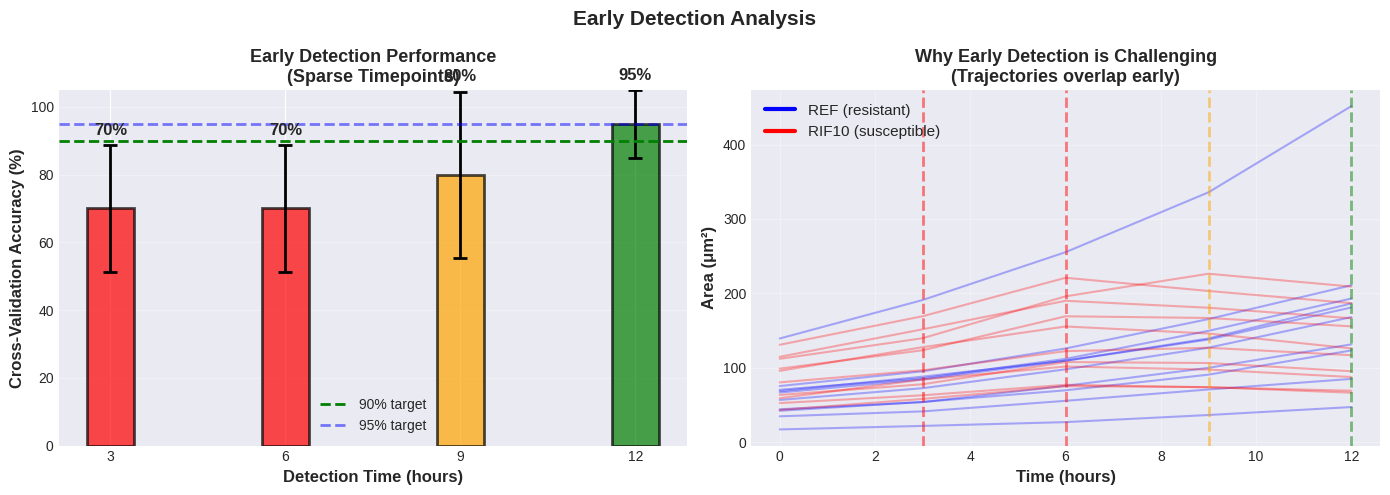

In [18]:
# Visualize early detection results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy over time
hours = [r['hour'] for r in results_early]
accs = [r['accuracy']*100 for r in results_early]
stds = [r['std']*100 for r in results_early]

colors = ['red' if a < 80 else 'orange' if a < 90 else 'green' for a in accs]
bars = ax1.bar(hours, accs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

ax1.errorbar(hours, accs, yerr=stds, fmt='none', ecolor='black',
             capsize=5, capthick=2, linewidth=2)

# Add labels
for hour, acc, std in zip(hours, accs, stds):
    ax1.text(hour, acc + std + 3, f'{acc:.0f}%',
            ha='center', fontsize=12, fontweight='bold')

# Add threshold lines
ax1.axhline(y=90, color='green', linestyle='--', linewidth=2, label='90% target')
ax1.axhline(y=95, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='95% target')

ax1.set_xlabel('Detection Time (hours)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cross-Validation Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Early Detection Performance\n(Sparse Timepoints)',
              fontsize=13, fontweight='bold')
ax1.set_ylim([0, 105])
ax1.set_xticks(hours)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3, axis='y')

# Plot 2: Trajectories showing why early detection is hard
ax2.plot(SPARSE_TIMEPOINTS, ref_sparse.T, 'b-', alpha=0.3, linewidth=1.5)
ax2.plot(SPARSE_TIMEPOINTS, rif10_sparse.T, 'r-', alpha=0.3, linewidth=1.5)
ax2.plot([], [], 'b-', linewidth=3, label='REF (resistant)')
ax2.plot([], [], 'r-', linewidth=3, label='RIF10 (susceptible)')

# Mark detection timepoints
for r in results_early:
    hour = r['hour']
    acc = r['accuracy']
    color = 'red' if acc < 0.80 else 'orange' if acc < 0.90 else 'green'
    ax2.axvline(x=hour, color=color, linestyle='--', alpha=0.5, linewidth=2)

ax2.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Area (μm²)', fontsize=12, fontweight='bold')
ax2.set_title('Why Early Detection is Challenging\n(Trajectories overlap early)',
              fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.suptitle('Early Detection Analysis', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'early_detection.png', dpi=300, bbox_inches='tight')
plt.show()


## 6. Results Summary

In [19]:
print("CLASSIFICATION SUMMARY")

print("\n1. THRESHOLD-BASED CLASSIFICATION:")
print(f"   REF:   {(ref_classification['Classification'] == 'RESISTANT').sum()}/10 correctly classified")
print(f"   RIF10: {(rif10_classification['Classification'] == 'SUSCEPTIBLE').sum()}/20 correctly classified")

print("\n2. MACHINE LEARNING CLASSIFICATION:")
print(f"   Overall Accuracy: {cv_scores.mean()*100:.1f}% ± {cv_scores.std()*100:.1f}%")
print(f"   Features Used: 5 timepoints (0h, 3h, 6h, 9h, 12h)")

print("\n3. EARLY DETECTION:")
if reliable:
    print(f"   Earliest reliable detection: {earliest['hour']}h ({earliest['accuracy']:.1%} accuracy)")
    print(f"   Time savings: {12 - earliest['hour']}h ({(12-earliest['hour'])/12*100:.0f}% reduction)")
else:
    print(f"   90% accuracy achieved at 12h only")


CLASSIFICATION SUMMARY

1. THRESHOLD-BASED CLASSIFICATION:
   REF:   10/10 correctly classified
   RIF10: 20/20 correctly classified

2. MACHINE LEARNING CLASSIFICATION:
   Overall Accuracy: 95.0% ± 10.0%
   Features Used: 5 timepoints (0h, 3h, 6h, 9h, 12h)

3. EARLY DETECTION:
   Earliest reliable detection: 12h (95.0% accuracy)
   Time savings: 0h (0% reduction)
